## Teoría

- nodo raíz (root node) -> contiene todos los datos
- nodos de decisión (decision node) -> basados en algún criterio
- ramas (branches)
- nodos hoja (leaf nodes) -> Decisión final o la predicción del árbol

Podemos construir un árbol de decisión fácilmente en Python utilizando la librería scikit-learn y las funciones DecisionTreeClassifier y DecisionTreeRegressor. Los hiperparámetros más importanrtes son:
- max_depth: La profundidad máxima del árbol. Esto limita cuántas divisiones puede tener, lo cual es útil para prevenir el sobreajuste. Si este valor es None, entonces los nodos se expanden hasta que las hojas sean puras o hasta que todas las hojas contengan menos muestras que min_samples_split.
- min_samples_split: El número mínimo de muestras necesarias para dividir un nodo. Si un nodo tiene menos muestras que min_samples_split, entonces no se dividirá, incluso aunque no sea puro. Ayuda a prevenir el sobreajuste.
- min_samples_leaf: El número mínimo de muestras que debe haber en un nodo hoja. Un nodo se dividirá si al hacerlo se crean al menos min_samples_leaf muestras en cada uno de los hijos. Esto también ayuda a prevenir el sobreajuste.
- max_features: El número máximo de características a considerar al buscar la mejor división. Si max_features es None, entonces se considerarán todas las características. Reducir este número puede hacer que el modelo sea más simple y rápido de entrenar, pero también puede hacer que pase por alto algunas relaciones importantes.
- criterion: La función para medir la calidad de una división. Dependiendo de la naturaleza del árbol (clasificar o regresar), las opciones varían. Este hiperparámetro es el encargado de elegir qué variable se va a ramificar.

Paso 1. Lectura del conjunto de datos procesado

In [ ]:
import os
import pandas as pd

# Extraer datos
# Se ha mantenido todos los Excels, pero con el DecisionTreeClassifier solo se usan los datos naturales
# es decir, con outliers y sin outliers
BASE_PATH = "../data/processed"
TRAIN_PATHS = [
    "X_train_con_outliers.xlsx",
    "X_train_sin_outliers.xlsx"
]

TRAIN_DATASETS = []
for path in TRAIN_PATHS:
    TRAIN_DATASETS.append(
        # pd.read_excel(BASE_PATH + "/" + path)
        pd.read_excel(f"{BASE_PATH}/{path}")
        # pd.read_excel(os.path.join(BASE_PATH, path))
    )

TEST_PATHS = [
    "X_test_con_outliers.xlsx",
    "X_test_sin_outliers.xlsx"
]

TEST_DATASETS = []
for path in TEST_PATHS:
    TEST_DATASETS.append(
        pd.read_excel(f"{BASE_PATH}/{path}")
    )

y_train = pd.read_excel(f"{BASE_PATH}/y_train.xlsx")
y_test = pd.read_excel(f"{BASE_PATH}/y_test.xlsx")

Paso 2: Inicialización y entrenamiento del modelo

In [1]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# crea el modelo, entrena el modelo, guardas el target de train y de test. Sacar la precisión para comparar cual es el mejor de todos
results_accuracy = []

for index, dataset in enumerate(TRAIN_DATASETS):
    print(index)
    model = DecisionTreeClassifier(random_state = 42)
    model.fit(dataset, y_train)
    
    y_pred_train = model.predict(dataset)   # x_train
    y_pred_test = model.predict(TEST_DATASETS[index])   # x_text

    results_accuracy.append(
        {
            "train": accuracy_score(y_train, y_pred_train),
            "test": accuracy_score(y_test, y_pred_test)
        }
    )
 
    # print tiempo que ha tardado
results_accuracy

NameError: name 'TRAIN_DATASETS' is not defined

Paso 3: Predicción del modelo

Se observa que se han obtenido valores perfectos en train, y buenos valores en test.

In [ ]:
from sklearn import linear_model
from sklearn.model_selection import ParameterGrid, GridSearchCV, RandomizedSearchCV
import warnings
warnings.filterwarnings("ignore")
path_train = "X_train_con_outliers.xlsx"
path_test = "X_test_con_outliers.xlsx"
winner_train = pd.read_excel(f"{BASE_PATH}/{path_train}")
winner_test = pd.read_excel(f"{BASE_PATH}/{path_test}")

### Decision Tree Classifier

In [ ]:
model = DecisionTreeClassifier(random_state=42)
# Definir el grid de hiperparámetros
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 20, 50],
    'min_samples_split': [2, 3, 4, 5, 10, 20],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'max_features': [None, 'sqrt', 'log2'],
    'max_leaf_nodes': [None, 10, 20, 50, 100],
    'min_impurity_decrease': [0.0, 0.01, 0.1],
    'ccp_alpha': [0.0, 0.01, 0.1, 1.0]
}
# El mejor
param_grid = {
    'criterion' : ['entropy'],
    'max_depth' : [5], 
    'max_leaf_nodes' : [10],
    'min_samples_leaf' : [10]
}

# GridSearchCV para encontrar los mejores parámetros
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
train_regularized = grid_search.fit(winner_train, y_train)

final_model = train_regularized.best_estimator_
final_model



DecisionTreeClassifier(criterion='entropy', max_depth=5, max_leaf_nodes=10,
                       min_samples_leaf=10, random_state=42)

In [ ]:
# DecisionTreeClassifier(criterion='entropy', max_depth=5, max_leaf_nodes=10,
#                        min_samples_leaf=10, random_state=42)

In [ ]:
y_pred_train = final_model.predict(winner_train)
accuracy_score(y_pred_train, y_train)

0.7996742671009772

In [ ]:
y_pred_test = final_model.predict(winner_test)
accuracy_score(y_pred_test, y_test)

0.7727272727272727

#### Metric Train > Metric Test -> Overfitting: El modelo ha aprendido demasiado de train -> El modelo no ha generalizado
    1. Feature selection
    2. El modelo no sea el apropiado
    3. El modelo no está bien optimizado
    4. Reformular train y test
#### Metric Train < Metric Test -> Underfitting
    1. Reformular train y test
    2. El modelo no sea el apropiado
#### Metric Train ~ Metric Test y los resultados son malos ->
    1. El modelo no sea el apropiado
    2. El modelo no está bien optimizado
    3. (Feature selection)

### FEATURE SELECTION

Si hubiera overfitting, es decir x_train > x_test, se procedería a realizar el feature selection. Se realiza para practicar

In [ ]:
BASE_PATH = "../data/processed/assets"
TRAIN_PATHS = [
    "clean_with_outliers__train_k_4.csv",
    "clean_with_outliers__train_k_5.csv",
    "clean_with_outliers__train_k_6.csv",
    "clean_with_outliers__train_k_7.csv"
]

TRAIN_DATASETS = []
for path in TRAIN_PATHS:
    TRAIN_DATASETS.append(
        # pd.read_excel(BASE_PATH + "/" + path)
        pd.read_csv(f"{BASE_PATH}/{path}")
        # pd.read_excel(os.path.join(BASE_PATH, path))
    )

TEST_PATHS = [
    "clean_with_outliers__test_k_4.csv",
    "clean_with_outliers__test_k_5.csv",
    "clean_with_outliers__test_k_6.csv",
    "clean_with_outliers__test_k_7.csv"
]

TEST_DATASETS = []
for path in TEST_PATHS:
    TEST_DATASETS.append(
        pd.read_csv(f"{BASE_PATH}/{path}")
    )

***

No se haría así (crear el modelo, entrenarlo y sacar la precisión), ya que se debe de comprobar con el feature selection los valores del accuracy tras haberlo aplicado la reducción de valores con k.
Es decir, este bloque de comprobar los resultados no debería de estar, pero lo dejo por si en el futuro me surgen dudas.

In [ ]:
# crea el modelo, entrena el modelo, guardas el target de train y de test. Sacar la precisión para comparar cual es el mejor de todos
results_accuracy = []

for index, dataset in enumerate(TRAIN_DATASETS):
    print(index)
    model = DecisionTreeClassifier(random_state = 42)
    model.fit(dataset, y_train)
    
    y_pred_train = model.predict(dataset)   # x_train
    y_pred_test = model.predict(TEST_DATASETS[index])   # x_text

    results_accuracy.append(
        {
            "train": accuracy_score(y_train, y_pred_train),
            "test": accuracy_score(y_test, y_pred_test)
        }
    )
 
    # print tiempo que ha tardado
results_accuracy

0
1
2
3


[{'train': 1.0, 'test': 0.6818181818181818},
 {'train': 1.0, 'test': 0.7077922077922078},
 {'train': 1.0, 'test': 0.7142857142857143},
 {'train': 1.0, 'test': 0.7597402597402597}]

***

In [ ]:
# Se prueba el Feature Selection 
# Al tratarse de un valor del % se considera aceptable para el modelo
base_path = "../data/processed/assets"
train_paths = "clean_with_outliers__train_k_5.csv"
x_train = pd.read_csv(f"{base_path}/{train_paths}", sep=",")


test_paths = "clean_with_outliers__test_k_5.csv"
x_test = pd.read_csv(f"{base_path}/{test_paths}", sep=",")


In [ ]:
model = DecisionTreeClassifier(random_state=42)
# Definir el grid de hiperparámetros
param_grid = {
     'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 20, 50],
    'min_samples_split': [2, 3, 4, 5, 10, 20],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'max_features': [None, 'sqrt', 'log2'],
    'max_leaf_nodes': [None, 10, 20, 50, 100],
    'min_impurity_decrease': [0.0, 0.01, 0.1],
    'ccp_alpha': [0.0, 0.01, 0.1, 1.0]
}

# El mejor
# param_grid = {
#     'criterion' : ['entropy'],
#     'max_depth' : [5], 
#     'max_leaf_nodes' : [10],
#     'min_samples_leaf' : [10]
# }

# GridSearchCV para encontrar los mejores parámetros
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
train_regularized = grid_search.fit(x_train, y_train) 

final_model_feature_selection = train_regularized.best_estimator_

final_model_feature_selection
# Guardar en pickle porque tienes los hiperparámetros y el modelo. _best_estimator



DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=5,
                       random_state=42)

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=5,
                       random_state=42)

In [ ]:
y_pred_train_feature_selection = final_model_feature_selection.predict(x_train)
accuracy_score(y_pred_train_feature_selection, y_train)

0.8241042345276873

In [ ]:
y_pred_test_feature_selection = final_model_feature_selection.predict(x_test)
accuracy_score(y_pred_test_feature_selection, y_test)

0.7727272727272727

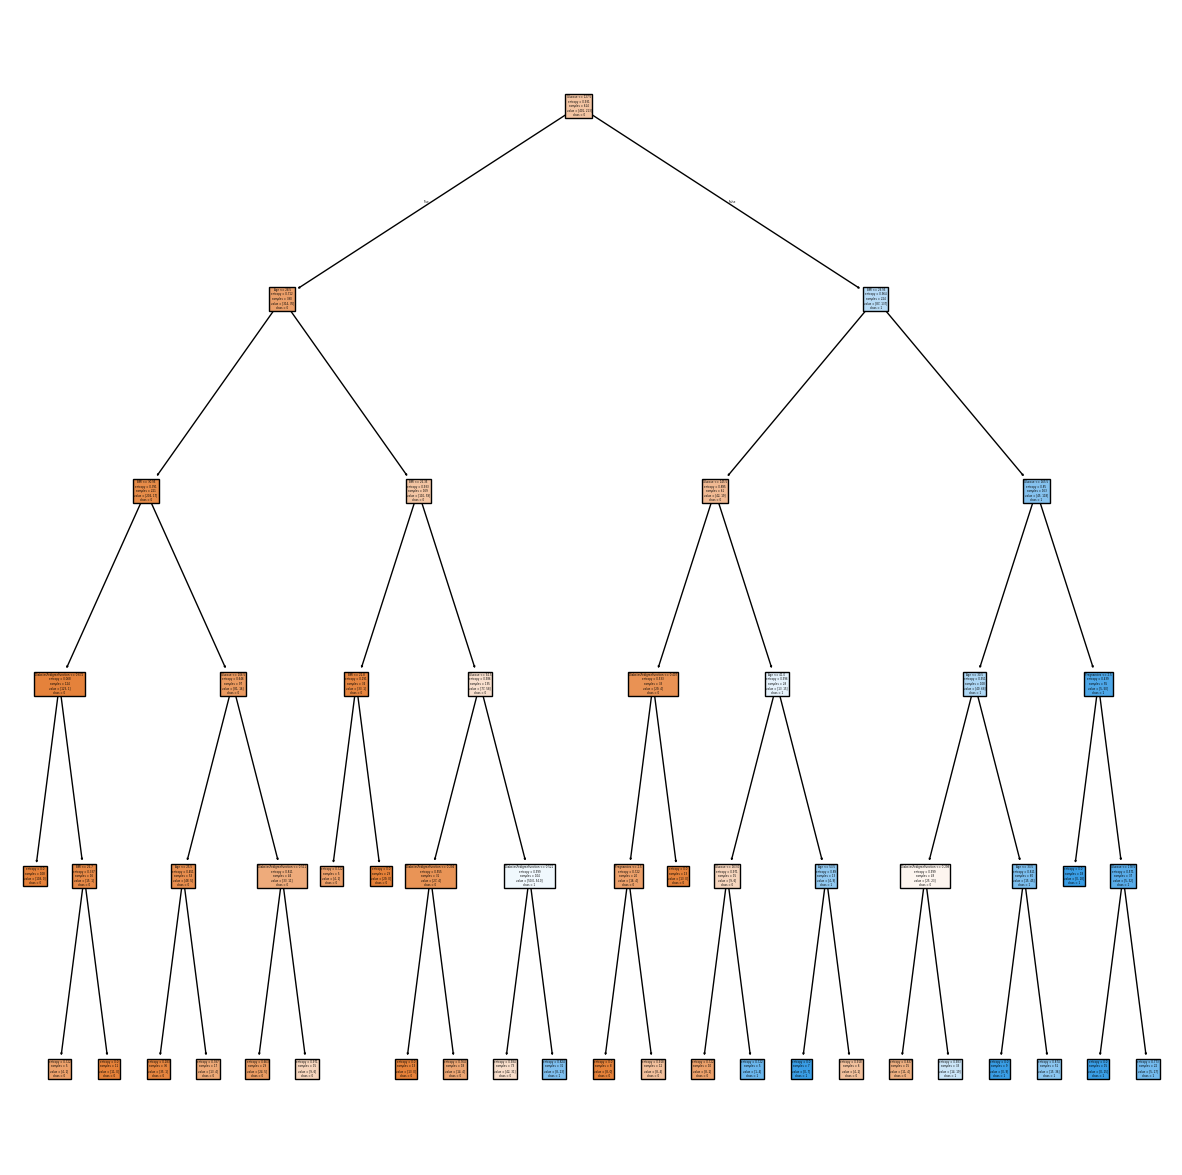

In [ ]:
from sklearn import tree
import matplotlib.pyplot as plt
model_columns = list(x_train.columns)
plt.figure(figsize=(15,15))
tree.plot_tree(
    final_model_feature_selection, # model
    max_depth = None, 
    feature_names = model_columns, 
    class_names = ["0", "1"], # target
    label = 'all', 
    filled = True,  # color
    impurity = True, 
    node_ids = False, 
    proportion = False, 
    rounded = False, 
    precision = 3, 
    ax = None, 
    fontsize = None)
plt.show()

Paso 4: Guardado del modelo

In [ ]:
from pickle import dump
base_path = os.getcwd()
model_path = "../models/decission_tree_classifier_default_42.pkl"
complete_path = os.path.join(base_path, model_path)

In [ ]:

dump(model, open(complete_path, "wb"))